In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stock = '13003'

In [3]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)
df.drop(columns=['bid', 'ask'], inplace=True)

In [4]:
df.head()

,Unnamed: 0,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2000,2013-09-11 13:28:00,419.8,420.0,419.90,3953.0,4528.0,0.0,0.067799
2001,2013-09-11 13:29:00,419.7,420.0,419.85,3384.0,4318.0,1.0,0.121267
2002,2013-09-11 13:32:00,419.8,420.0,419.90,4000.0,2244.0,1.0,-0.281230
2003,2013-09-11 13:35:00,419.9,420.0,419.95,4600.0,1978.0,0.0,-0.398601
2004,2013-09-11 13:37:00,419.8,420.0,419.90,2941.0,6126.0,1.0,0.351274


In [5]:
def add_mid_states(df, n):
    additionals = {}
    for j in range(n, 0, -1):
        additionals['mid_{}'.format(j)] = []
    for i, row in df.iterrows():
        for j in range(n, 0, -1):
            if i - j > 0 and i - j in df.index:
                additionals['mid_{}'.format(j)].append(df.loc[i-j]['mid_price'])
            else:
                additionals['mid_{}'.format(j)].append(None)
    for k in additionals.keys():
        if len(additionals[k]) == len(df):
            df[k] = additionals[k]
    return df

number_of_states = 10
add_mid_states(df, number_of_states)

,Unnamed: 0,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,mid_10,mid_9,mid_8,mid_7,mid_6,mid_5,mid_4,mid_3,mid_2,mid_1
2000,2013-09-11 13:28:00,419.8,420.0,419.90,3953.0,4528.0,0.0,0.067799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,2013-09-11 13:29:00,419.7,420.0,419.85,3384.0,4318.0,1.0,0.121267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,419.90
2002,2013-09-11 13:32:00,419.8,420.0,419.90,4000.0,2244.0,1.0,-0.281230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,419.90,419.85
2003,2013-09-11 13:35:00,419.9,420.0,419.95,4600.0,1978.0,0.0,-0.398601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,419.90,419.85,419.90
2004,2013-09-11 13:37:00,419.8,420.0,419.90,2941.0,6126.0,1.0,0.351274,NaN,NaN,NaN,NaN,NaN,NaN,419.90,419.85,419.90,419.95
2005,2013-09-11 13:40:00,419.9,420.0,419.95,4707.0,763.0,0.0,-0.721024,NaN,NaN,NaN,NaN,NaN,419.90,419.85,419.90,419.95,419.90
2006,2013-09-11 13:50:00,419.8,419.9,419.85,1255.0,2146.0,1.0,0.261982,NaN,NaN,NaN,NaN,419.90,419.85,419.90,419.95,419.90,419.95
2007,2013-09-11 13:51:00,419.9,420.0,419.95,2085.0,1263.0,1.0,-0.245520,NaN,NaN,NaN,419.90,419.85,419.90,419.95,419.90,419.95,419.85
2008,2013-09-11 13:55:00,419.9,420.2,420.05,1492.0,13524.0,0.0,0.801279,NaN,NaN,419.90,419.85,419.90,419.95,419.90,419.95,419.85,419.95
2009,2013-09-11 13:56:00,419.9,420.0,419.95,2482.0,10988.0,0.0,0.631477,NaN,419.90,419.85,419.90,419.95,419.90,419.95,419.85,419.95,420.05


In [6]:
def fit_linear(df, n):
    labels = ['mid_{}'.format(i) for i in range(1, n+1)]
    coefs = {}
    for i in range(1, n+1):
        coefs['coef_{}'.format(i)] = []
    for i, row in df.iterrows():
        reg = LinearRegression()
        y = row[labels]
        X = np.array(list(range(1, n+1))).reshape(-1, 1)
        X = np.vstack([X, [r ** 2 for r in X]]).reshape(n, 2)
        #X = np.vstack([X, [r ** 3 for r in X], [r ** 5 for r in X], [r ** 7 for r in X]]).reshape(n, 4)
        reg.fit(X, y)
        for j in range(len(reg.coef_)):
            coefs['coef_{}'.format(j+1)].append(reg.coef_[j])
    for k in coefs.keys():
        if len(coefs[k]) == len(df):
            df[k] = coefs[k]
    return df
df.dropna(inplace=True)
df = fit_linear(df, number_of_states)
        

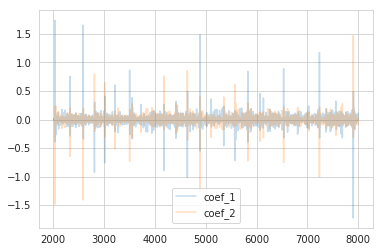

In [7]:
df.dropna(inplace=True)

states_labels = ['coef_{}'.format(i) for i in range(1, 3)]
df[states_labels].plot(alpha=0.25)

In [8]:
dbscan = cluster.AffinityPropagation() #(eps=0.0001, min_samples=2)
groups = dbscan.fit_predict(df[states_labels])
np.unique(dbscan.labels_)

array([   0,    1,    2, ..., 2800, 2801, 2802])

In [9]:
df['db'] = groups
for i in np.unique(dbscan.labels_):
    print(i, len(df[df['db'] == i]))

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 5
9 4
10 1
11 1
12 1
13 1
14 1
15 1
16 2
17 1
18 1
19 1
20 2
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 10
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 3
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 2
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 1
124 2
125 1
126 1
127 1
128 1
129 1
130 10
131 2
132 1
133 1
134 1
135 1
136 1
137 1
138 2
139 2
140 1
141 1
142 1
143 17
144 1
145 1
146 1
147 1
148 1
149 1
150 1
151 1
152 1
153 1
154 1
155 1
156 1
157 1
158 1
159 1
160 1
161 1
162 1
163 1
164 1
165 1
166 1
167 1
168 1
169 1
170 1
171 1
172 4
173 1
174 1
175 1
176 1
177 1
178 1
179 1
180 1
181 1
182 1
183 1
184

1377 1
1378 1
1379 1
1380 1
1381 1
1382 1
1383 1
1384 1
1385 1
1386 1
1387 1
1388 1
1389 1
1390 1
1391 1
1392 1
1393 3
1394 1
1395 1
1396 1
1397 1
1398 1
1399 1
1400 1
1401 1
1402 1
1403 1
1404 1
1405 1
1406 1
1407 1
1408 1
1409 1
1410 1
1411 1
1412 1
1413 2
1414 1
1415 1
1416 1
1417 1
1418 1
1419 1
1420 1
1421 1
1422 3
1423 62
1424 1
1425 1
1426 1
1427 1
1428 1
1429 1
1430 1
1431 1
1432 1
1433 1
1434 3
1435 1
1436 1
1437 1
1438 1
1439 1
1440 1
1441 1
1442 1
1443 1
1444 1
1445 1
1446 1
1447 1
1448 1
1449 1
1450 1
1451 1
1452 1
1453 1
1454 1
1455 1
1456 1
1457 2
1458 1
1459 1
1460 1
1461 1
1462 1
1463 1
1464 1
1465 1
1466 1
1467 1
1468 1
1469 1
1470 60
1471 1
1472 1
1473 1
1474 6
1475 1
1476 1
1477 2
1478 1
1479 1
1480 88
1481 1
1482 1
1483 1
1484 1
1485 1
1486 1
1487 1
1488 1
1489 1
1490 9
1491 1
1492 10
1493 1
1494 1
1495 1
1496 1
1497 1
1498 1
1499 1
1500 1
1501 1
1502 1
1503 1
1504 1
1505 1
1506 1
1507 1
1508 1
1509 1
1510 1
1511 1
1512 1
1513 1
1514 1
1515 1
1516 1
1517 1
1518 1
15

2722 1
2723 1
2724 1
2725 1
2726 1
2727 1
2728 1
2729 1
2730 1
2731 1
2732 1
2733 1
2734 1
2735 1
2736 1
2737 2
2738 1
2739 1
2740 1
2741 1
2742 1
2743 1
2744 2
2745 1
2746 1
2747 1
2748 1
2749 2
2750 15
2751 1
2752 1
2753 1
2754 1
2755 1
2756 1
2757 1
2758 1
2759 1
2760 1
2761 1
2762 1
2763 1
2764 1
2765 1
2766 1
2767 1
2768 1
2769 1
2770 1
2771 1
2772 1
2773 34
2774 1
2775 1
2776 1
2777 1
2778 1
2779 1
2780 1
2781 13
2782 1
2783 1
2784 1
2785 1
2786 1
2787 1
2788 11
2789 1
2790 1
2791 1
2792 1
2793 1
2794 1
2795 1
2796 10
2797 1
2798 1
2799 1
2800 1
2801 1
2802 1


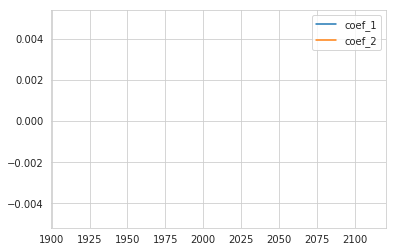

In [10]:
df[df['db'] == 0][states_labels].plot()

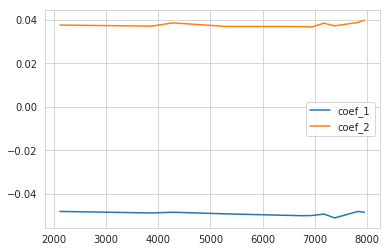

In [11]:
df[df['db'] == 34][states_labels].plot()

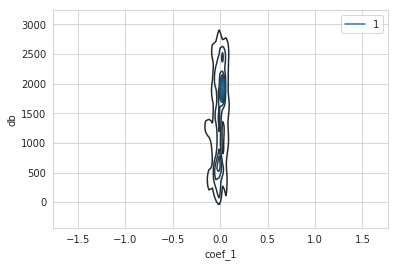

In [12]:
sns.kdeplot(df['coef_1'], df['db'], label='1')
#sns.kdeplot(df['coef_2'], df['db'], label='2', color='r')
plt.legend()

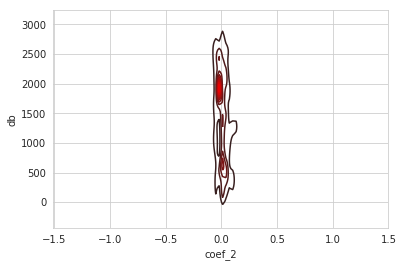

In [13]:
sns.kdeplot(df['coef_2'], df['db'], label='2', color='r')